# Happy Birthday, Robert!

## Bayesian Statistics, Markov-Chain Monte Carlo, and PyMC

#### Jack Bennetto
#### July 6, 2018

Before you do imports you need to install pymc3. Try using conda, like this:

`conda install -c conda-forge pymc3`

In [3]:
from scipy import stats
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn.datasets
%matplotlib inline

## Objectives

 * Describe sampling a posterior using Markov-chain Monte Carlo.
 * Build a simple model with pymc and calculate a trace.

Earlier we talked a bit about Bayesian statistics. To review:

Suppose we're considering some hypothesis $H$ and we've collected some data $\mathbf{X}$.
$$ P(H|\mathbf{X}) = \frac{P(\mathbf{X}|H) P(H)}{P(\mathbf{X})} $$

Each term has a name.

* $P(H)$ is the *prior probability*
* $P(\mathbf{X}|H)$ is the *likelihood*.
* $P(\mathbf{X})$ is the *normalizing constant*.
* $P(H|\mathbf{X})$ is the *posterior probability*.


If there are a bunch of hypotheses $H_1, H_2, ... H_n$, we could write this as

$$\begin{align}
P(H_i|\mathbf{X}) & = \frac{P(\mathbf{X}|H_i) P(H_i)}{P(\mathbf{X})}\\
         & = \frac{P(\mathbf{X}|H_i) P(H_i)}{\sum_{j=0}^{n} P(\mathbf{X}|H_j) P(H_j)}
\end{align}
$$

Here we see the normalizing constant is the likelihood times the prior summed over all possible hypothesis. In other words, it's the constant (independent of hypothesis) needed to be multiplied by all the numerators so that they all add up to one.



When you worked that out computationally you saw calculating the normalizing constant was difficult, particularly in cases with an infinite number of possible hypotheses. One approach we took was to use conjugate priors. That's fine for click-through rates but is only available for simple models. The other is to divide the hypothesis space into many slices, but that becomes computationally impossible in high-dimensional space. In particular, that means giving the same attention to areas that are likely in the posterior as those that are almost impossible.

A third choice is random sampling. We call this a *monte-carlo* approach. In particular we sample many points (hypotheses) from the posterior distribution, transitioning from each point to the next, in what is called Markov-Chain Monte Carlo (MCMC). Although there are a number of different approaches to this, but a common one, called the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, works like this.

First, we start at a given set of values. We then adjust them slightly (in such way that the probabilities are symmetric) and consider a new point. If it has a higher value for the pdf of the posterior, we accept it automatically. If it's lower, we accept it with a probability of the fraction of the ratio with the pdf at the current point. Otherwise  we reject the new point. We repeat this many, many times.

Let's try this out to sample something we already understand, a multivariate normal distribution. We haven't talked about multivariate distributions yet, but they just take non-scalar parameters. This is a two dimensional distribution (because we want to draw it) centered at the origin with a variance of 1 in one direction and 2 in the other.

In [278]:
dist = stats.multivariate_normal([0, 0], [[2, 0], [0, 1]])

We also need a starting position; let's start with the origin. We're going to keep track of all successful steps in a list.

In [279]:
current = np.array([0, 0])
steps = [current]

And we need another distribution to randomly general possible steps. We'll use a normal distribution for this too, but a bit smaller.

In [237]:
step_generator = stats.multivariate_normal([0, 0], [[0.5, 0], [0, 0.5]])

Now we'll generate a new position, based on the `current` position plus a random step from `step_generator`

In [238]:
new = current + step_generator.rvs()

Now we need to decide whether to "accept" the new position (in which case it becomes the `current`, and we try again from there) or "reject" it (in which case we ignore the `new` position and try again).

We'll accept the new position if
 * the value of the distribution at `new` is greater then that at `current`, or
 * the value at `new` is less, with a probability equal to the ratio of the values.

Note (and this is important) that although here's we're using the pdf, we really just need something proportional to the pdf since we just care about the ratio of the values at different locations.

In [257]:
if dist.pdf(new) > dist.pdf(current) or \
   np.random.rand() < (dist.pdf(new) / dist.pdf(current)):
    print(f"Accepted:  Current pdf: {dist.pdf(current):.4f}   new pdf {dist.pdf(new):.4f}  ")
    current = new
    steps.append(current)
else:
    print(f"Rejected:  Current pdf: {dist.pdf(current):.4f}   new pdf {dist.pdf(new):.4f}  ")


Accepted:  Current pdf: 0.1114   new pdf 0.1114  


Let's put that in a function, and then run it a bunch of times. Since we want to visualize the results we'll keep track of all the rejects as well; ordinarily we can just ignore them.

In [280]:
def consider_step(dist, step_generator, accepted, rejected):
    """Make one step using the Metropolis-hastings algorithm."""
    if len(accepted) > 0:
        current = accepted[-1][1]
    else:
        current = np.array([0, 0])

    new = current + step_generator.rvs()
    if (dist.pdf(new) > dist.pdf(current) or
            np.random.rand() < (dist.pdf(new) / dist.pdf(current))):
        print(f"Accepted:  Current pdf: {dist.pdf(current):.4f}   new pdf {dist.pdf(new):.4f}  ")
        accepted.append((current, new))
    else:
        print(f"Rejected:  Current pdf: {dist.pdf(current):.4f}   new pdf {dist.pdf(new):.4f}  ")
        rejected.append((current, new))

In [320]:
accepted = []
rejected = []

In [323]:
for _ in range(1000):
    consider_step(dist, step_generator, accepted, rejected)

Accepted:  Current pdf: 0.0097   new pdf 0.0161  
Accepted:  Current pdf: 0.0161   new pdf 0.0160  
Rejected:  Current pdf: 0.0160   new pdf 0.0043  
Accepted:  Current pdf: 0.0160   new pdf 0.0176  
Accepted:  Current pdf: 0.0176   new pdf 0.0196  
Accepted:  Current pdf: 0.0196   new pdf 0.0141  
Rejected:  Current pdf: 0.0141   new pdf 0.0033  
Accepted:  Current pdf: 0.0141   new pdf 0.0116  
Accepted:  Current pdf: 0.0116   new pdf 0.0101  
Accepted:  Current pdf: 0.0101   new pdf 0.0323  
Accepted:  Current pdf: 0.0323   new pdf 0.0295  
Accepted:  Current pdf: 0.0295   new pdf 0.0476  
Accepted:  Current pdf: 0.0476   new pdf 0.0760  
Rejected:  Current pdf: 0.0760   new pdf 0.0193  
Accepted:  Current pdf: 0.0760   new pdf 0.0739  
Accepted:  Current pdf: 0.0739   new pdf 0.1069  
Accepted:  Current pdf: 0.1069   new pdf 0.0758  
Rejected:  Current pdf: 0.0758   new pdf 0.0066  
Accepted:  Current pdf: 0.0758   new pdf 0.0615  
Rejected:  Current pdf: 0.0615   new pdf 0.0390  


Accepted:  Current pdf: 0.0605   new pdf 0.0514  
Rejected:  Current pdf: 0.0514   new pdf 0.0364  
Accepted:  Current pdf: 0.0514   new pdf 0.1032  
Accepted:  Current pdf: 0.1032   new pdf 0.1023  
Rejected:  Current pdf: 0.1023   new pdf 0.0985  
Accepted:  Current pdf: 0.1023   new pdf 0.1102  
Accepted:  Current pdf: 0.1102   new pdf 0.0453  
Accepted:  Current pdf: 0.0453   new pdf 0.1092  
Accepted:  Current pdf: 0.1092   new pdf 0.0963  
Rejected:  Current pdf: 0.0963   new pdf 0.0498  
Accepted:  Current pdf: 0.0963   new pdf 0.0670  
Rejected:  Current pdf: 0.0670   new pdf 0.0352  
Rejected:  Current pdf: 0.0670   new pdf 0.0166  
Rejected:  Current pdf: 0.0670   new pdf 0.0470  
Accepted:  Current pdf: 0.0670   new pdf 0.0578  
Rejected:  Current pdf: 0.0578   new pdf 0.0171  
Accepted:  Current pdf: 0.0578   new pdf 0.0121  
Accepted:  Current pdf: 0.0121   new pdf 0.0267  
Accepted:  Current pdf: 0.0267   new pdf 0.0096  
Accepted:  Current pdf: 0.0096   new pdf 0.0425  


Accepted:  Current pdf: 0.1000   new pdf 0.0782  
Accepted:  Current pdf: 0.0782   new pdf 0.1031  
Rejected:  Current pdf: 0.1031   new pdf 0.0862  
Accepted:  Current pdf: 0.1031   new pdf 0.0980  
Accepted:  Current pdf: 0.0980   new pdf 0.1051  
Accepted:  Current pdf: 0.1051   new pdf 0.0774  
Accepted:  Current pdf: 0.0774   new pdf 0.1094  
Rejected:  Current pdf: 0.1094   new pdf 0.0796  
Accepted:  Current pdf: 0.1094   new pdf 0.1088  
Accepted:  Current pdf: 0.1088   new pdf 0.0890  
Accepted:  Current pdf: 0.0890   new pdf 0.0664  
Accepted:  Current pdf: 0.0664   new pdf 0.0385  
Accepted:  Current pdf: 0.0385   new pdf 0.0457  
Accepted:  Current pdf: 0.0457   new pdf 0.0430  
Rejected:  Current pdf: 0.0430   new pdf 0.0146  
Accepted:  Current pdf: 0.0430   new pdf 0.1002  
Accepted:  Current pdf: 0.1002   new pdf 0.1047  
Accepted:  Current pdf: 0.1047   new pdf 0.0897  
Accepted:  Current pdf: 0.0897   new pdf 0.1038  
Rejected:  Current pdf: 0.1038   new pdf 0.0501  


Accepted:  Current pdf: 0.0224   new pdf 0.0267  
Accepted:  Current pdf: 0.0267   new pdf 0.0289  
Accepted:  Current pdf: 0.0289   new pdf 0.0254  
Rejected:  Current pdf: 0.0254   new pdf 0.0133  
Accepted:  Current pdf: 0.0254   new pdf 0.0241  
Accepted:  Current pdf: 0.0241   new pdf 0.0065  
Rejected:  Current pdf: 0.0065   new pdf 0.0013  
Accepted:  Current pdf: 0.0065   new pdf 0.0092  
Accepted:  Current pdf: 0.0092   new pdf 0.0161  
Accepted:  Current pdf: 0.0161   new pdf 0.0389  
Accepted:  Current pdf: 0.0389   new pdf 0.0376  
Accepted:  Current pdf: 0.0376   new pdf 0.0965  
Accepted:  Current pdf: 0.0965   new pdf 0.1067  
Accepted:  Current pdf: 0.1067   new pdf 0.0930  
Accepted:  Current pdf: 0.0930   new pdf 0.0798  
Accepted:  Current pdf: 0.0798   new pdf 0.0842  
Accepted:  Current pdf: 0.0842   new pdf 0.0871  
Accepted:  Current pdf: 0.0871   new pdf 0.1094  
Rejected:  Current pdf: 0.1094   new pdf 0.0610  
Accepted:  Current pdf: 0.1094   new pdf 0.0887  


Accepted:  Current pdf: 0.0871   new pdf 0.0855  
Accepted:  Current pdf: 0.0855   new pdf 0.0701  
Rejected:  Current pdf: 0.0701   new pdf 0.0142  
Accepted:  Current pdf: 0.0701   new pdf 0.0668  
Accepted:  Current pdf: 0.0668   new pdf 0.0942  
Rejected:  Current pdf: 0.0942   new pdf 0.0626  
Accepted:  Current pdf: 0.0942   new pdf 0.0487  
Rejected:  Current pdf: 0.0487   new pdf 0.0199  
Rejected:  Current pdf: 0.0487   new pdf 0.0135  
Accepted:  Current pdf: 0.0487   new pdf 0.0699  
Accepted:  Current pdf: 0.0699   new pdf 0.0892  
Rejected:  Current pdf: 0.0892   new pdf 0.0310  
Rejected:  Current pdf: 0.0892   new pdf 0.0552  
Accepted:  Current pdf: 0.0892   new pdf 0.0981  
Rejected:  Current pdf: 0.0981   new pdf 0.0286  
Accepted:  Current pdf: 0.0981   new pdf 0.0422  
Rejected:  Current pdf: 0.0422   new pdf 0.0152  
Accepted:  Current pdf: 0.0422   new pdf 0.0652  
Accepted:  Current pdf: 0.0652   new pdf 0.1012  
Rejected:  Current pdf: 0.1012   new pdf 0.0711  


Let's graph that, along with ellipses at 1 and 2 standard deviations.

(-2.5, 2.5)

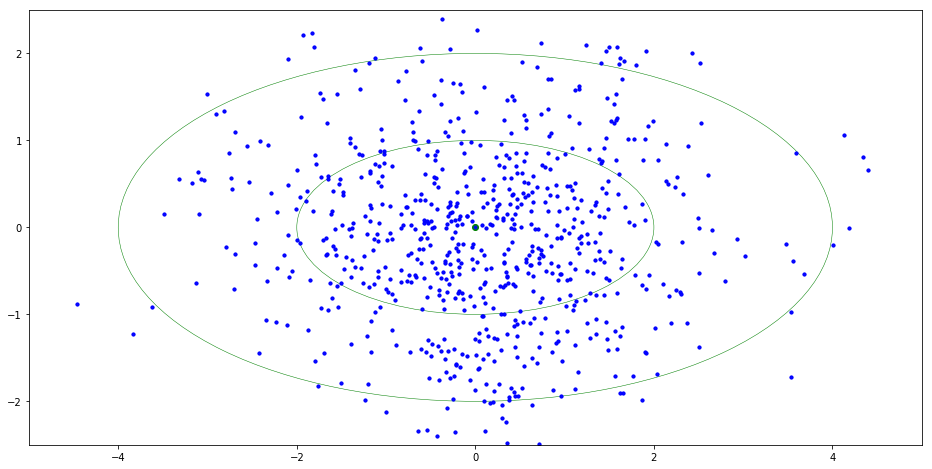

In [324]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([0], [0], 'go')

for step in accepted:
    ax.plot(*zip(step[0], step[1]), 'b.', lw=0.5, alpha=0.8)
#for step in rejected:
#    ax.plot(*zip(step[0], step[1]), 'r.-', lw=0.5, alpha=0.8)

ax.add_artist(matplotlib.patches.Ellipse(xy=(0, 0),
                                         width=4,
                                         height=2,
                                         fill=False,
                                         ec='g',
                                         lw=0.5))
ax.add_artist(matplotlib.patches.Ellipse(xy=(0, 0),
                                         width=8,
                                         height=4,
                                         fill=False,
                                         ec='g',
                                         lw=0.5))
ax.set_xlim(-5, 5)
ax.set_ylim(-2.5, 2.5)

The accepted points are can be treated as an IID sample from the distribution, and then we can draw conclusions from that (e.g., what's the probability that $x_1 > 2$?

**Question:** are the points actually IID?



Today most MCMC approaches use more sophisticated algorithms (pymc3 uses NUTS (No-U-Turn Sampling) by default), but the idea is often similar.

## Experimenting with pymc

Let's start with the coin-flip/CTR example we've seem a couple times before. In this we have data on successes and failures and we want to determine the value of some unknown click-through rate. First, let's make some data!

In [296]:
prob_actual = 0.10
data_ctr = stats.bernoulli(prob_actual).rvs(100)
data_ctr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [297]:
data_ctr.mean()

0.080000000000000002

The pymc interface uses the `with` statement in python to specify a model with which we'll be operating. The first time we interact with it we'll need to call the constructor and assign it to a variable with `as`; after that we just refer to that variable. Any variables created are added to that model object automatically, and any sampling or optimization is done on that model.

In general, there are a couple different types of variables. First, we can create a variable that represents some prior distribution of a variable. Here we're just starting with a uniform distribution for a prior. Each object created in the model (usually) needs a name so we can identity it later. 

In [302]:
with pm.Model() as model_ctr:
    prob = pm.Uniform('prob', 0, 1)

The other type of variable in the model is a likelihood, specifying the observed data.

In [303]:
with model_ctr:
    observed = pm.Bernoulli('observed', prob, observed=data_ctr)

Now we do some sampling! The result of sampling is often called a *trace*.

In [304]:
with model_ctr:
    trace = pm.sample(5000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prob_interval__]
100%|██████████| 5500/5500 [00:04<00:00, 1138.41it/s]


In [308]:
trace['prob'].shape

(10000,)

The result of `sample` will contain values for all of the variables, distributed (if we have enough) in the same manner as the posterior distribution of those variables. Let's visualize them.

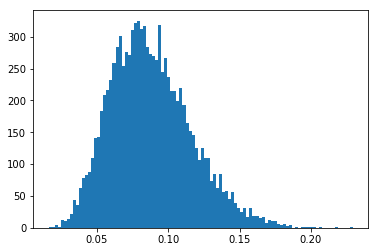

In [309]:
fig, ax = plt.subplots()
ax.hist(trace['prob'], bins=100)
plt.show()

Questions:

Why doesn't it peak at the actual value for the probability (`prob_actual`)?

Why isn't this very smooth?

Is this a beta distribution?

What else can we do with this?

## A (slightly) harder example

Bernoulli distributions aren't all that exciting. Let's sample a few points from a normal distribution and  try to recover the parameters.

In [325]:
mu_actual = 5
sigma_actual = 2
data = stats.norm(mu_actual, sigma_actual).rvs(10)

What do we have?

In [327]:
print("mean = {:.3f} sd = {:.3f}".format(data.mean(), data.std()))

mean = 5.458 sd = 1.240


For now let's assume we know `sigma`, just to make it easier. We'll take a uniform prior for `mu` but assume it's between 0 and 10.

In [313]:
with pm.Model() as model_normal:
    # prior
    mu = pm.Uniform("mu", 0, 10)
    # likelihood
    observed = pm.Normal("observed", mu, 2, observed=data)

We might want to start my calculating the maximum *a posteriori* (MAP) value for the `mu`.

Question: what is MAP?

In [315]:
with model_normal:
    estimate = pm.find_MAP()
estimate

logp = -27.376, ||grad|| = 5.5779: 100%|██████████| 6/6 [00:00<00:00, 1006.03it/s]


{'mu': array(5.892455555996378), 'mu_interval__': array(0.3608474222512808)}

In [316]:
with model_normal:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_interval__]
100%|██████████| 10500/10500 [00:08<00:00, 1276.73it/s]


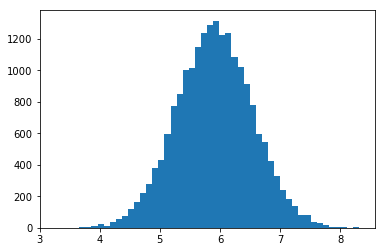

In [317]:
fig, ax = plt.subplots()
ax.hist(trace['mu'], bins=50)
plt.show()

But really we want to estimate both the `mu` and `sigma`. We just need to put both in the model.

In [337]:
with pm.Model() as model_normal2:
    # prior
    mu = pm.Uniform('mu', 0, 10)
    sigma = pm.Uniform('sigma', 0, 10)
    # likelihood
    observed = pm.Normal("observed", mu, sigma, observed=data)

In [338]:
with model_normal2:
    estimate = pm.find_MAP()

logp = -20.946, ||grad|| = 5.7571e-08: 100%|██████████| 12/12 [00:00<00:00, 1022.59it/s]  


Are these the right values?

In [339]:
print("                   mu   sigma")
print("MAP estimate      {:5.3f} {:5.3f}".format(float(estimate['mu']), float(estimate['sigma'])))
print("sample statistics {:5.3f} {:5.3f}".format(data.mean(), data.std()))
print("actual            {:5.3f} {:5.3f}".format(mu_actual, sigma_actual))

                   mu   sigma
MAP estimate      5.458 1.240
sample statistics 5.458 1.240
actual            5.000 2.000


In [340]:
with model_normal2:
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, mu_interval__]
100%|██████████| 11000/11000 [00:16<00:00, 656.65it/s]


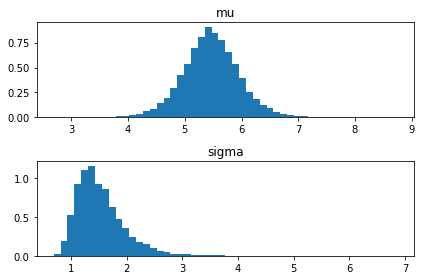

In [341]:
fig, axes = plt.subplots(2)
axes[0].hist(trace['mu'], bins=50, normed=True)
axes[1].hist(trace['sigma'], bins=50, normed=True)
axes[0].set_title("mu")
axes[1].set_title("sigma")
plt.tight_layout()
plt.show()

There's a function to plot this automatically.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122afc2b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126bdb240>]], dtype=object)

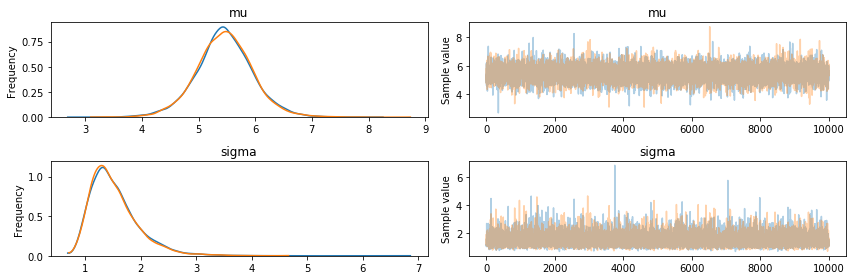

In [342]:
pm.traceplot(trace)

A scatter plot will show us the how they are related.

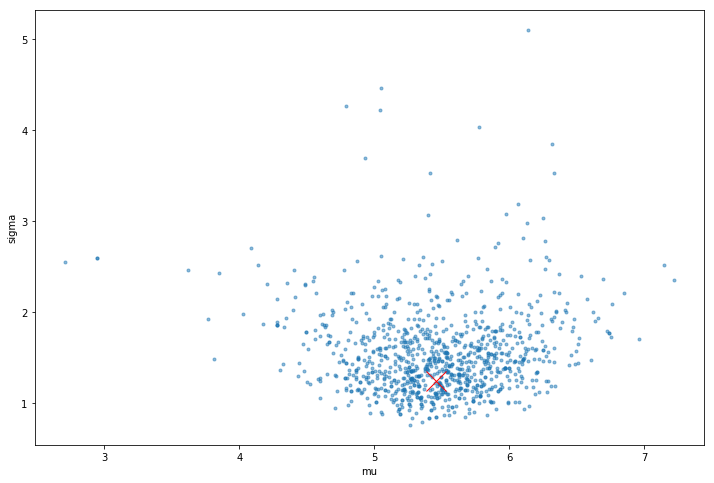

In [336]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(trace['mu'][:1000], trace['sigma'][:1000], '.', alpha=0.5)
#ax.plot(trace['mu'][:1000], trace['sigma'][:1000], '-', alpha=0.5)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.plot(data.mean(), data.std(), 'rx', ms=20)
plt.show()

Note that these aren't independent. If sigma is small, then mu must be near the optimal value.

## Linear modeling

Suppose we want to build a Linear Model with pymc. We'll use the boston dataset.

In [356]:
boston_data = sklearn.datasets.load_boston()
df_boston = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
df_boston['target'] = boston_data.target
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [345]:
X = df_boston.values[:, :-1]
y = df_boston.values[:, -1]

We can build the model as before, but this time the observed data includes values for `X` as well as the target. This is also different in that `beta` is now an array (`shape=(13,)`) since we have a prior for the coefficient for each feature.

In [360]:
with pm.Model() as model_boston:
    intercept = pm.Normal('intercept', 0, 100)
    sd = pm.HalfNormal('sd', 100)
    beta = pm.Normal('beta', 0, 1000, shape=(13,))
    observed = pm.Normal('observed',
                         intercept + (beta * X).sum(axis=1),
                         sd,
                         observed=y)

In [361]:
with model_boston:
    trace = pm.sample(500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, sd_log__, intercept]
100%|██████████| 1000/1000 [00:42<00:00, 23.61it/s]
The acceptance probability does not match the target. It is 0.885015891546, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.905868775634, but should be close to 0.8. Try to increase the number of tuning steps.


The `pymc` has a simpler format for linear modeling that abstracts away most of these details. In this case the model is specified with a formula, similar to R (using the `patsy` package also used by `statsmodels`).

In [362]:
with pm.Model() as model_boston:
    pm.glm.GLM.from_formula('target ~ LSTAT', df_boston)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, LSTAT, Intercept]
100%|██████████| 1500/1500 [00:04<00:00, 339.41it/s]
The acceptance probability does not match the target. It is 0.885049668688, but should be close to 0.8. Try to increase the number of tuning steps.


We can plot that out. Since we have the standard deviation, we can show the credible ranges.

(100, 400000)


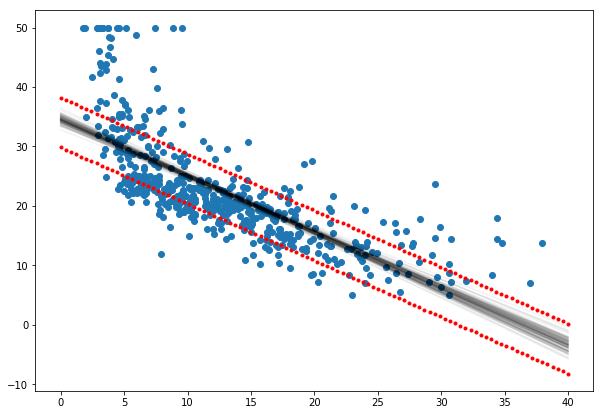

In [364]:
xmin = 0
xmax = 40
n_xpts = 100
n_rnd = 200
fix, ax = plt.subplots(figsize=(10,7))
ax.scatter(df_boston.LSTAT, df_boston.target)
for i, point in enumerate(trace):
    if i%10 == 0:
        ax.plot([xmin, xmax],
                [point['Intercept'] + point['LSTAT']*xmin,
                 point['Intercept'] + point['LSTAT']*xmax],
                'k', alpha=0.05)

xpts = np.linspace(xmin, xmax, n_xpts).reshape(-1, 1, 1)
rnd = stats.norm(0,1).rvs(n_rnd).reshape(-1, 1)
ypts = trace['Intercept'] + xpts * trace['LSTAT'] + rnd*trace['sd']
ypts = ypts.reshape(n_xpts, -1)
xpts = xpts.reshape(-1)
print (ypts.shape)
for xpt, ypt in zip(xpts, ypts):
    ax.plot([xpt], [np.percentile(ypt, 75)], 'r.')
    ax.plot([xpt], [np.percentile(ypt, 25)], 'r.')

## Hierarchical Modeling

Although this is letting us see the probabilities of the results, it isn't letting us consider fundamentally different problem. Consider the scores of five classes of students on a test. The test is the same, but the students have different teachers, classrooms, materials, etc.

In [365]:
df_scores = pd.read_csv('data/scores.csv')

In [366]:
df_scores.head()

,group,score
0,1,0.90
1,1,0.78
2,1,0.68
3,1,0.32
4,1,0.47


In [367]:
df_scores.score.describe()

count    81.000000
mean      0.753827
std       0.169105
min       0.050000
25%       0.660000
50%       0.780000
75%       0.880000
max       1.000000
Name: score, dtype: float64

In [368]:
df_scores.groupby('group').mean()

,score
group,
1,0.766316
2,0.736364
3,0.793077
4,0.773333
5,0.708500


We might wonder whether different teachers and such have a significant effect on the scores.

How would we approach the as frequentists?

As Bayesians, we can choose a more nuanced approach.

In [369]:
with pm.Model() as model_scores:
    mu = pm.Uniform('mu', 0, 1)
    sigma = pm.HalfNormal('sigma', 1)
    sd = pm.HalfNormal('sd', 1)
    eta1 = pm.Normal('eta1', mu, sigma)
    eta2 = pm.Normal('eta2', mu, sigma)
    eta3 = pm.Normal('eta3', mu, sigma)
    eta4 = pm.Normal('eta4', mu, sigma)
    eta5 = pm.Normal('eta5', mu, sigma)
    obs1 = pm.Normal('obs1', eta1, sd, observed=df_scores[df_scores.group==1].values)
    obs2 = pm.Normal('obs2', eta2, sd, observed=df_scores[df_scores.group==2].values)
    obs3 = pm.Normal('obs3', eta3, sd, observed=df_scores[df_scores.group==3].values)
    obs4 = pm.Normal('obs4', eta4, sd, observed=df_scores[df_scores.group==4].values)
    obs5 = pm.Normal('obs5', eta5, sd, observed=df_scores[df_scores.group==5].values)
                    

In [370]:
with model_scores:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eta5, eta4, eta3, eta2, eta1, sd_log__, sigma_log__, mu_interval__]
100%|██████████| 10500/10500 [00:33<00:00, 310.95it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a290ef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1269d3c88>]], dtype=object)

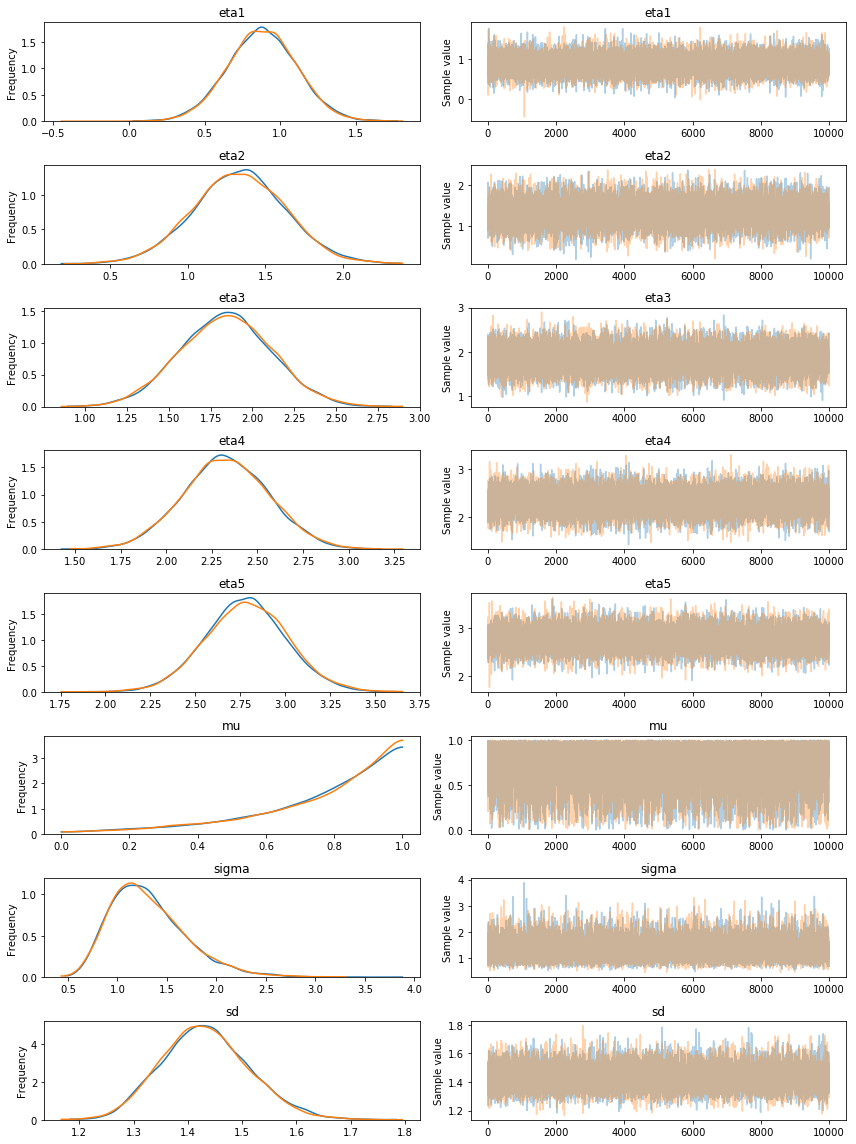

In [372]:
pm.traceplot(trace)